<a href="https://colab.research.google.com/github/hiimjupter/COS40007/blob/main/Portfolio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
import joblib

In [126]:
def save_data(df, output_path):
    """
    Save the DataFrame to the specified file path.
    Args:
    - df (pd.DataFrame): The DataFrame to save.
    - output_path (str): The path to save the CSV file.

    Returns:
    - None
    """
    try:
        df.to_csv(output_path, index=False)
        print(f"Data saved successfully to {output_path}.")
    except Exception as e:
        print(f"Error saving data: {e}")

In [127]:
def load_data(file_path):
    """
    Load data from a specified file path.
    Args:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: Loaded DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data('/content/drive/MyDrive/COS40007/Portfolio3/Dataset/vegemite.csv')
# Shuffle the dataset to randomize the data points
df = shuffle(df, random_state=42)
print("Successfully shuffled data")

Data loaded successfully. Shape: (15237, 47)
Successfully shuffled data


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15237 entries, 14921 to 7270
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FFTE Feed tank level SP        15237 non-null  float64
 1   FFTE Production solids SP      15237 non-null  float64
 2   FFTE Steam pressure SP         15237 non-null  float64
 3   TFE Out flow SP                15237 non-null  float64
 4   TFE Production solids SP       15237 non-null  float64
 5   TFE Vacuum pressure SP         15237 non-null  float64
 6   TFE Steam pressure SP          15237 non-null  float64
 7   TFE Steam temperature SP       15237 non-null  float64
 8   FFTE Feed flow SP              15237 non-null  float64
 9   FFTE Out steam temp SP         15237 non-null  float64
 10  Extract tank Level             15237 non-null  float64
 11  Extract tank Out flow PV       15237 non-null  float64
 12  FFTE Discharge density         15237 non-null  f

In [129]:
def remove_constant_features(df):
    """
    Remove columns from a DataFrame that have constant values.

    Parameters:
    df (pd.DataFrame): The input pandas DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with constant columns removed.
    """
    # Identify columns with constant values
    constant_columns = df.loc[:, df.nunique() == 1]

    for col in constant_columns:
        print(f"Remove '{col}' as constant column")

    # Drop the constant columns
    df_reduced = df.drop(columns=constant_columns)

    return df_reduced

df = remove_constant_features(df)
df.shape

Remove 'TFE Steam temperature SP' as constant column
Remove 'TFE Product out temperature' as constant column


(15237, 45)

In [130]:
def preprocess_data(df):
    """
    Preprocess the DataFrame with data cleaning steps:
    1. Fill missing values with median.
    2. Remove duplicate rows.
    3. Handle outliers using IQR method (replace with upper and lower bounds).

    Args:
    - df (pd.DataFrame): The DataFrame to process.

    Returns:
    - pd.DataFrame: Preprocessed DataFrame.
    """
    # 1. Fill missing values with median
    print(f"Fill {df.isna().sum().sum()} NaN rows with median value")
    df.fillna(df.mean(), inplace=True)

    # 2. Remove duplicate rows
    initial_shape = df.shape
    df.drop_duplicates(inplace=True)
    final_shape = df.shape
    print(f"Removed duplicates: {initial_shape[0] - final_shape[0]} rows dropped.")

    return df

df_cleaned = preprocess_data(df)

Fill 0 NaN rows with median value
Removed duplicates: 0 rows dropped.


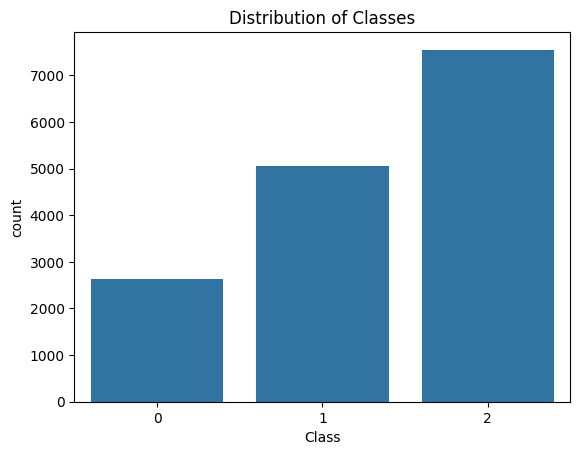

In [131]:
# Plot Class distribution
sns.countplot(x='Class', data=df_cleaned)
plt.title('Distribution of Classes')
plt.show()

In [132]:
threshold = 10
categorical_columns = df_cleaned.nunique()[df_cleaned.nunique() < threshold]
print(f"Categorical columns with unique values less than {threshold}:")
print(categorical_columns)

Categorical columns with unique values less than 10:
FFTE Feed tank level SP    3
FFTE Pump 1                5
FFTE Pump 1 - 2            4
FFTE Pump 2                5
TFE Motor speed            3
Class                      3
dtype: int64


In [133]:
def convert_low_cardinality_integers_to_categorical(df, unique_threshold=10, verbose=True):
    # Create a copy to avoid modifying the original DataFrame
    df_converted = df.copy()

    # Iterate through each column in the DataFrame
    for col in df_converted.columns:
        # Check if the column is of number type
        if pd.api.types.is_numeric_dtype(df_converted[col]):
            unique_values = df_converted[col].nunique(dropna=True)
            # If the number of unique values is less than or equal to the threshold
            if unique_values <= unique_threshold:
                # Convert the column to 'category' dtype
                df_converted[col] = df_converted[col].astype('category')
                if verbose:
                    print(f"Converted column '{col}' to 'category' (unique values: {unique_values}).")

    return df_converted

# Example usage:
df_final = convert_low_cardinality_integers_to_categorical(df_cleaned)

Converted column 'FFTE Feed tank level SP' to 'category' (unique values: 3).
Converted column 'FFTE Pump 1' to 'category' (unique values: 5).
Converted column 'FFTE Pump 1 - 2' to 'category' (unique values: 4).
Converted column 'FFTE Pump 2' to 'category' (unique values: 5).
Converted column 'TFE Motor speed' to 'category' (unique values: 3).
Converted column 'Class' to 'category' (unique values: 3).


In [134]:
# # Initialize PCA
# pca = PCA(n_components=15)

# # Applying PCA
# pca_result = pca.fit_transform(df_converted.iloc[:, :-1])  # Exclude 'Class' column for PCA

# # Creating a new DataFrame for the PCA results
# df_final = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(15)])

# # Adding the 'Class' column back to the DataFrame
# df_final['Class'] = df_converted['Class'].values

# df_final.info()

In [135]:
# Extract 1000 data points with near-equal distribution of each class (at least 300 from each class)
# Perform stratified sampling to get equal distribution from the classes
df_class_0 = df_final[df_final['Class'] == 0].sample(334, random_state=42)
df_class_1 = df_final[df_final['Class'] == 1].sample(333, random_state=42)
df_class_2 = df_final[df_final['Class'] == 2].sample(333, random_state=42)

# Concatenate the sampled data points to form the test set
df_similar = pd.concat([df_class_0, df_class_1, df_class_2])

# The remaining data points will be used for training
df_remaining = df_final.drop(df_similar.index)

# Verify the class distribution in the test dataset
test_class_distribution = df_similar['Class'].value_counts()

df_similar.shape, df_remaining.shape, test_class_distribution

((1000, 45),
 (14237, 45),
 Class
 0    334
 1    333
 2    333
 Name: count, dtype: int64)

In [136]:
X = df_remaining.drop(columns=['Class'], axis=1)
y = df_remaining['Class']

print("------------------------------------")
print("Class distribution after SMOTE:")
print(y.value_counts())

# Initialize SMOTE with a random state for reproducibility
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to generate synthetic samples
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# Verify the new class distribution after SMOTE
print("------------------------------------")
print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())
print("------------------------------------")
print(f"Potential missing values: \n{X_train_resampled.isna().sum()}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.3, stratify=y_train_resampled, random_state=42)

------------------------------------
Class distribution after SMOTE:
Class
2    7215
1    4714
0    2308
Name: count, dtype: int64
------------------------------------
Class distribution after SMOTE:
Class
0    7215
1    7215
2    7215
Name: count, dtype: int64
------------------------------------
Potential missing values: 
FFTE Feed tank level SP          398
FFTE Production solids SP          0
FFTE Steam pressure SP             0
TFE Out flow SP                    0
TFE Production solids SP           0
TFE Vacuum pressure SP             0
TFE Steam pressure SP              0
FFTE Feed flow SP                  0
FFTE Out steam temp SP             0
Extract tank Level                 0
Extract tank Out flow PV           0
FFTE Discharge density             0
FFTE Discharge solids              0
FFTE Feed flow rate PV             0
FFTE Feed tank level PV            0
FFTE Heat temperature 1            0
FFTE Heat temperature 2            0
FFTE Heat temperature 3            0
FFTE Out

In [137]:
# X_train_1, X_test_1, y_train_1, y_test_1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

# # -----------------------------------
# # 6. Define Models with Pipelines
# # -----------------------------------
# # Define pipelines to handle missing values for models that need it
# gbc_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('model', GradientBoostingClassifier(max_depth=5, random_state=42))
# ])

# svm_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('model', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))
# ])

# lrc_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('model', LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=2000, random_state=42))
# ])

# # Models to train (using pipelines for models that require imputation)
# models = {
#     'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
#     'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
#     'GradientBoosting': gbc_pipeline,
#     'SVM': svm_pipeline,
#     'LogisticRegression': lrc_pipeline,
# }

# # -----------------------------------
# # 7. Train and Evaluate Models
# # -----------------------------------
# results = {}
# report_list = []  # List to store individual model reports

# for name, model in models.items():
#     print(f"\nTraining and evaluating model: {name}")
#     # Train the model on the resampled training set
#     model.fit(X_train_1, y_train_1)
#     # Predict on the test set
#     y_pred = model.predict(X_test_1)
#     # Generate classification report
#     report = classification_report(y_test_1, y_pred, output_dict=True)
#     # Convert the report to a DataFrame
#     report_df = pd.DataFrame(report).transpose()
#     # Add a column for the model name
#     report_df['Model'] = name
#     # Append to the list
#     report_list.append(report_df)

# # -----------------------------------
# # 8. Compile and Save Results
# # -----------------------------------
# # Combine all individual reports into a single DataFrame
# results_df = pd.concat(report_list, ignore_index=True)

# # Rearrange columns to place 'Model' first
# cols = results_df.columns.tolist()
# cols = ['Model'] + [col for col in cols if col != 'Model']
# results_df = results_df[cols]

# # Save the results to a CSV file
# results_df.to_csv('/content/drive/MyDrive/COS40007/Portfolio3/Results/classification_results.csv', index=False)
# print("\nClassification results have been saved to 'classification_results.csv'.")

# # -----------------------------------
# # 9. Display Results in a Better Format
# # -----------------------------------
# # For better readability in the console, we'll display the DataFrame with proper formatting
# # Set pandas display options
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 1000)

# # Optionally, you can round the metrics for cleaner display
# results_df_rounded = results_df.round(3)

# # Display the results
# print("\nClassification Report for All Models:\n")
# print(results_df_rounded)

In [138]:
# # -----------------------------------
# # 10. Identify Best k
# # -----------------------------------
X_train_2, X_test_2, y_train_2, y_test_2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

# # To find the best k, we'll track the performance for each k and select the one with the highest F1-score (macro average)
# best_k = None
# best_f1 = -1
# performance_summary = []

# for k in range(1, 45):
#     print(f"\nEvaluating k={k}")
#     selector = SelectKBest(mutual_info_classif, k=k)

#     selector_pipeline = Pipeline([
#         ('imputer', SimpleImputer(strategy='mean')),
#         ('scaler', StandardScaler()),
#         ('selector', selector),
#     ])

#     # Fit the selector on the training data
#     selector_pipeline.fit(X_train_2, y_train_2)

#     # Transform both training and testing data
#     sel_X_train = selector_pipeline.transform(X_train_2)
#     sel_X_test = selector_pipeline.transform(X_test_2)

#     # Initialize the Logistic Regression model
#     lrc = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=2000, random_state=42)

#     # Train the model on the selected features
#     lrc.fit(sel_X_train, y_train_2)

#     # Predict on the test set
#     y_pred = lrc.predict(sel_X_test)

#     # Calculate F1-score (macro)
#     f1 = f1_score(y_test, y_pred, average='macro')
#     print(f"F1-score (macro) for k={k}: {f1}")

#     # Store the performance
#     performance_summary.append({'k': k, 'F1-score_macro': f1})

# # Convert the performance summary to a DataFrame
# performance_df = pd.DataFrame(performance_summary)

# # Identify the best k
# best_row = performance_df.loc[performance_df['F1-score_macro'].idxmax()]
# best_k = best_row['k']
# best_f1 = best_row['F1-score_macro']

# print(f"\nBest k: {best_k} with F1-score (macro): {best_f1}")

In [139]:
# # Plot the F1-score against k
# plt.figure(figsize=(10,8))
# sns.lineplot(data=performance_df, x='k', y='F1-score_macro', marker='o')
# plt.title('F1-score (Macro) vs. Number of Features (k)')
# plt.xlabel('Number of Features (k)')
# plt.ylabel('F1-score (Macro)')
# plt.xticks(range(1,45))
# plt.grid(True)
# plt.savefig('/content/drive/MyDrive/COS40007/Portfolio3/Images/f1_score_vs_k.png')  # Save the plot as an image file
# plt.show()

In [140]:
def train_and_predict(models, X_train, y_train, X_test):
    """
    Trains multiple models and stores their predictions on the test set.

    Parameters:
    - models (dict): Dictionary with model names as keys and sklearn estimators as values.
    - X_train (pd.DataFrame or np.ndarray): Training features.
    - y_train (pd.Series or np.ndarray): Training labels.
    - X_test (pd.DataFrame or np.ndarray): Testing features.

    Returns:
    - trained_models (dict): Dictionary of trained models.
    - predictions (dict): Dictionary of predictions for each model.
    """
    trained_models = {}
    predictions = {}

    for name, model in models.items():
        print(f"\nTraining model: {name}")
        # Train the model
        model.fit(X_train, y_train)
        trained_models[name] = model

        # Make predictions
        y_pred = model.predict(X_test)
        predictions[name] = y_pred

        print(f"Model {name} trained successfully.")

    return trained_models, predictions

In [141]:
from sklearn.model_selection import cross_val_predict

def train_evaluate_cross_val(models, X, y, cv=5):
    """
    Performs cross-validation training and stores predictions for each model.

    Parameters:
    - models (dict): Dictionary with model names as keys and sklearn estimators as values.
    - X (pd.DataFrame or np.ndarray): Features.
    - y (pd.Series or np.ndarray): Labels.
    - cv (int, optional): Number of cross-validation folds. Defaults to 5.

    Returns:
    - cross_val_predictions (dict): Dictionary of cross-validated predictions for each model.
    """
    cross_val_predictions = {}

    for name, model in models.items():
        print(f"\nPerforming cross-validation for model: {name}")
        y_pred_cv = cross_val_predict(model, X, y, cv=cv, method='predict')
        cross_val_predictions[name] = y_pred_cv
        print(f"Cross-validation predictions for {name} completed.")

    return cross_val_predictions

In [142]:
def evaluate_models(trained_models, predictions, y_test, output_csv_path=None, decimal_places=3):
    """
    Evaluates multiple trained models using their stored predictions.

    Parameters:
    - trained_models (dict): Dictionary of trained models.
    - predictions (dict): Dictionary of predictions for each model.
    - y_test (pd.Series or np.ndarray): True labels for the test set.
    - output_csv_path (str, optional): Path to save the results as a CSV file. Defaults to None.
    - decimal_places (int, optional): Number of decimal places to round the metrics. Defaults to 3.

    Returns:
    - results_df (pd.DataFrame): DataFrame containing Accuracy, Precision, Recall, and F1-Score for each model.
    """
    results_list = []

    for name, y_pred in predictions.items():
        print(f"\nEvaluating model: {name}")
        # Generate classification report as a dictionary
        report = classification_report(y_test, y_pred, output_dict=True)

        # Extract desired metrics
        accuracy = report.get('accuracy', 0)
        precision = report.get('weighted avg', {}).get('precision', 0)
        recall = report.get('weighted avg', {}).get('recall', 0)
        f1_score = report.get('weighted avg', {}).get('f1-score', 0)

        # Append the metrics to the results list
        results_list.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1_score
        })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results_list)

    # Round the metrics for better readability
    results_df = results_df.round(decimal_places)

    # Optionally, save the DataFrame to a CSV file
    if output_csv_path:
        results_df.to_csv(output_csv_path, index=False)
        print(f"\nClassification metrics have been saved to '{output_csv_path}'.")

    return results_df

In [143]:
def compile_classification_reports(trained_models, predictions, y_test, output_csv_path=None, decimal_places=7):
    """
    Compiles detailed classification reports for multiple trained models.

    Parameters:
    - trained_models (dict): Dictionary of trained models with model names as keys.
    - predictions (dict): Dictionary of predictions for each model with model names as keys.
    - y_test (pd.Series or np.ndarray): True labels for the test set.
    - output_csv_path (str, optional): Path to save the compiled reports as a CSV file. Defaults to None.
    - decimal_places (int, optional): Number of decimal places to round the metrics. Defaults to 3.

    Returns:
    - pd.DataFrame: A DataFrame containing detailed classification metrics for each model.
    """

    report_list = []  # List to store individual model reports

    for model_name, y_pred in predictions.items():
        print(f"\nCompiling classification report for model: {model_name}")

        # Generate classification report as a dictionary
        report_dict = classification_report(y_test, y_pred, output_dict=True)

        # Convert the report dictionary to a DataFrame
        report_df = pd.DataFrame(report_dict).transpose()

        # Add a column for the model name
        report_df['Model'] = model_name

        # Reset index to turn the 'class' labels into a column
        report_df.reset_index(inplace=True)
        report_df.rename(columns={'index': 'Class'}, inplace=True)

        # Append to the list
        report_list.append(report_df)

    # Combine all individual reports into a single DataFrame
    combined_report_df = pd.concat(report_list, ignore_index=True)

    # Optional: Rearrange columns to place 'Model' and 'Class' first
    columns_order = ['Model', 'Class'] + [col for col in combined_report_df.columns if col not in ['Model', 'Class']]
    combined_report_df = combined_report_df[columns_order]

    # Optionally, round the metrics for better readability
    combined_report_df = combined_report_df.round(decimal_places)

    # Optionally, save the combined report to a CSV file
    if output_csv_path:
        combined_report_df.to_csv(output_csv_path, index=False)
        print(f"\nClassification reports have been saved to '{output_csv_path}'.")

    # Display the combined report
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print("\nDetailed Classification Reports for All Models:\n")
    print(combined_report_df)

    return combined_report_df

In [144]:
def plot_confusion_matrices(y_test, predictions, models_per_row=3, figsize=(18, 12)):
    """
    Plots confusion matrices for each model using stored predictions.

    Parameters:
    - y_test (pd.Series or np.ndarray): True labels for the test set.
    - predictions (dict): Dictionary of predictions for each model.
    - models_per_row (int, optional): Number of confusion matrices per row. Defaults to 3.
    - figsize (tuple, optional): Size of the entire figure. Defaults to (18, 12).
    """
    num_models = len(predictions)
    rows = num_models // models_per_row + int(num_models % models_per_row != 0)
    cols = models_per_row if num_models >= models_per_row else num_models

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten in case of multiple rows

    for ax, (model_name, y_pred) in zip(axes, predictions.items()):
        # Generate the confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot the confusion matrix on the current axis
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                    xticklabels=np.unique(y_test),
                    yticklabels=np.unique(y_test),
                    ax=ax)

        ax.set_title(f'Confusion Matrix for {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    # If there are unused subplots, remove them
    for ax in axes[len(predictions):]:
        fig.delaxes(ax)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [145]:
# Define a common feature selector
feature_selector = SelectKBest(mutual_info_classif, k=42)

selector_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('selector', feature_selector),
    ])

# Fit the selector on the training data
selector_pipeline.fit(X_train_2, y_train_2)

# Define pipelines to handle missing values, scaling, feature selection, and modeling
gbc_pipeline_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('selector', selector_pipeline),
    ('model', GradientBoostingClassifier(max_depth=5, random_state=42))
])

svm_pipeline_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('selector', selector_pipeline),
    ('model', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))
])

lrc_pipeline_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('selector', selector_pipeline),
    ('model', LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=2000,  # Increased iterations to aid convergence
        random_state=42
    ))
])

# Models to train (using pipelines for models that require imputation, scaling, and feature selection)
models_2 = {
    'DecisionTree': Pipeline([
        ('selector', selector_pipeline),
        ('model', DecisionTreeClassifier(max_depth=5, random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('selector', selector_pipeline),
        ('model', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42))
    ]),
    'GradientBoosting': gbc_pipeline_2,
    'SVM': svm_pipeline_2,
    'LogisticRegression': lrc_pipeline_2,
}

In [146]:
# Train the models and store their predictions
trained_models, predictions = train_and_predict(
    models=models_2,
    X_train=X_train_2,
    y_train=y_train_2,
    X_test=X_test_2
)


Training model: DecisionTree
Model DecisionTree trained successfully.

Training model: RandomForest
Model RandomForest trained successfully.

Training model: GradientBoosting
Model GradientBoosting trained successfully.

Training model: SVM
Model SVM trained successfully.

Training model: LogisticRegression
Model LogisticRegression trained successfully.


In [147]:
cross_vl_predictions = train_evaluate_cross_val(
    models=models_2,
    X=X_train_2,
    y=y_train_2,
    cv=5
)


Performing cross-validation for model: DecisionTree
Cross-validation predictions for DecisionTree completed.

Performing cross-validation for model: RandomForest
Cross-validation predictions for RandomForest completed.

Performing cross-validation for model: GradientBoosting
Cross-validation predictions for GradientBoosting completed.

Performing cross-validation for model: SVM
Cross-validation predictions for SVM completed.

Performing cross-validation for model: LogisticRegression
Cross-validation predictions for LogisticRegression completed.


In [148]:
# Define the path where you want to save the results (optional)
report_csv = '/content/drive/MyDrive/COS40007/Portfolio3/Results/FSelection_results.csv'

detailed_reports_df = compile_classification_reports(
    trained_models=trained_models,
    predictions=predictions,
    y_test=y_test_2,
    output_csv_path=report_csv,
    decimal_places=7
)


Compiling classification report for model: DecisionTree

Compiling classification report for model: RandomForest

Compiling classification report for model: GradientBoosting

Compiling classification report for model: SVM

Compiling classification report for model: LogisticRegression

Classification reports have been saved to '/content/drive/MyDrive/COS40007/Portfolio3/Results/FSelection_results.csv'.

Detailed Classification Reports for All Models:

                 Model         Class  precision    recall  f1-score      support
0         DecisionTree             0   0.624945  0.657579  0.640847  2164.000000
1         DecisionTree             1   0.527692  0.633718  0.575866  2165.000000
2         DecisionTree             2   0.692022  0.516859  0.591750  2165.000000
3         DecisionTree      accuracy   0.602710  0.602710  0.602710     0.602710
4         DecisionTree     macro avg   0.614887  0.602719  0.602821  6494.000000
5         DecisionTree  weighted avg   0.614885  0.602710 

In [149]:
# Define the path where you want to save the results (optional)
output_csv = '/content/drive/MyDrive/COS40007/Portfolio3/Results/metrics.csv'

# Evaluate the models
results_df = evaluate_models(
    trained_models=trained_models,
    predictions=predictions,
    y_test=y_test_2,
    output_csv_path=output_csv,
    decimal_places=7
)

# Display the results
print("\nClassification Metrics for All Models:\n")
print(results_df)


Evaluating model: DecisionTree

Evaluating model: RandomForest

Evaluating model: GradientBoosting

Evaluating model: SVM

Evaluating model: LogisticRegression

Classification metrics have been saved to '/content/drive/MyDrive/COS40007/Portfolio3/Results/metrics.csv'.

Classification Metrics for All Models:

                Model  Accuracy  Precision    Recall  F1-Score
0        DecisionTree  0.602710   0.614885  0.602710  0.602815
1        RandomForest  0.994764   0.994765  0.994764  0.994763
2    GradientBoosting  0.989067   0.989064  0.989067  0.989063
3                 SVM  0.903449   0.904169  0.903449  0.903155
4  LogisticRegression  0.536957   0.533662  0.536957  0.532236


In [152]:
# Define the path where you want to save the results (optional)
cross_vl_csv = '/content/drive/MyDrive/COS40007/Portfolio3/Results/cross_vl.csv'

# Evaluate the models
cross_results_df = evaluate_models(
    trained_models=trained_models,
    predictions=cross_vl_predictions,
    y_test=y_train_2,
    output_csv_path=cross_vl_csv,
    decimal_places=7
)

# Display the results
print("\nClassification Metrics for All Models:\n")
print(cross_results_df)


Evaluating model: DecisionTree

Evaluating model: RandomForest

Evaluating model: GradientBoosting

Evaluating model: SVM

Evaluating model: LogisticRegression

Classification metrics have been saved to '/content/drive/MyDrive/COS40007/Portfolio3/Results/cross_vl.csv'.

Classification Metrics for All Models:

                Model  Accuracy  Precision    Recall  F1-Score
0        DecisionTree  0.609135   0.612841  0.609135  0.608807
1        RandomForest  0.993334   0.993333  0.993334  0.993332
2    GradientBoosting  0.988450   0.988452  0.988450  0.988446
3                 SVM  0.892482   0.893705  0.892482  0.891910
4  LogisticRegression  0.531780   0.526083  0.531780  0.525094


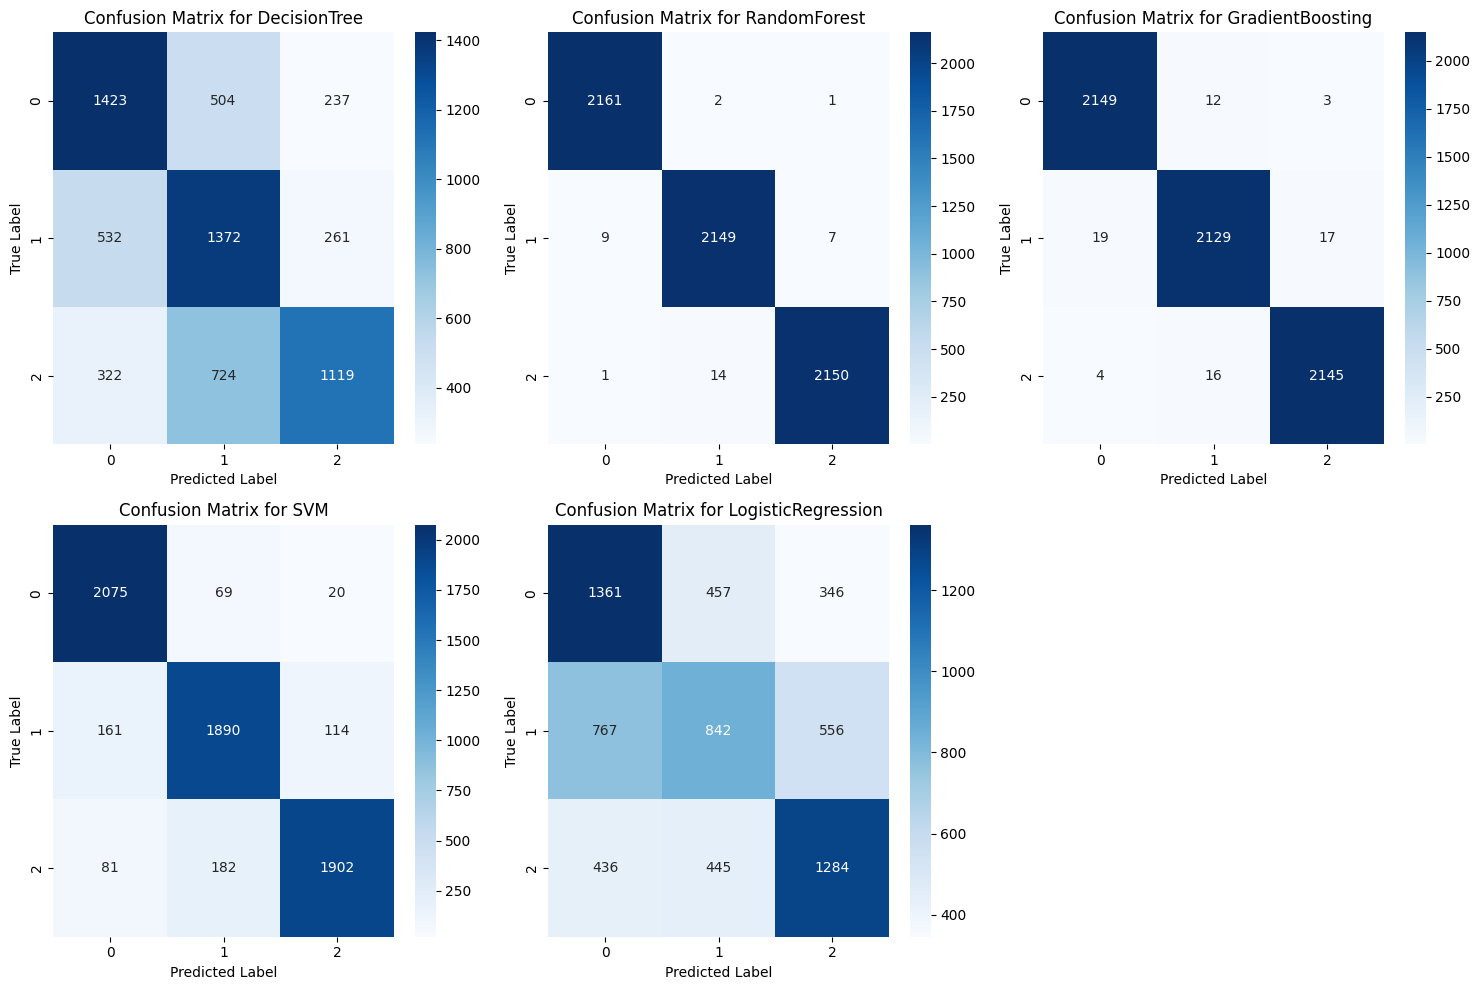

In [150]:
# Plot confusion matrices for all models
plot_confusion_matrices(
    y_test=y_test_2,
    predictions=predictions,
    models_per_row=3,  # Adjust based on the number of models
    figsize=(15, 10)    # Adjust the figure size as needed
)

In [170]:
# Function to save models
def save_model(model, filename):
    """Save a model using joblib."""
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

# Function to load models
def load_model(filename):
    """Load a saved model using joblib."""
    model = joblib.load(filename)
    print(f"Model loaded from {filename}")
    return model

final_model = {'Random Forest': models_2['RandomForest']}
other_model = {
    'Decision Tree': models_2['DecisionTree'],
    'Gradient Boosting': models_2['GradientBoosting'],
    'SVM': models_2['SVM'],
    'Logistic Regression': models_2['LogisticRegression'],
}

# Save RandomForest model
save_model(final_model, '/content/drive/MyDrive/COS40007/Portfolio3/Models/random_forest_model.joblib')
save_model(other_model, '/content/drive/MyDrive/COS40007/Portfolio3/Models/other_models.joblib')

Model saved as /content/drive/MyDrive/COS40007/Portfolio3/Models/random_forest_model.joblib
Model saved as /content/drive/MyDrive/COS40007/Portfolio3/Models/other_models.joblib


In [171]:
# Step 12
df_unseen = df_similar.copy()

df_unseen.info()

X_unseen = df_unseen.drop(columns=['Class'], axis=1)
y_unseen = df_unseen['Class']

# Step 13
loaded_rf_model = load_model('/content/drive/MyDrive/COS40007/Portfolio3/Models/random_forest_model.joblib')
loaded_other_models = load_model('/content/drive/MyDrive/COS40007/Portfolio3/Models/other_models.joblib')

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 5300 to 12018
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   FFTE Feed tank level SP        1000 non-null   category
 1   FFTE Production solids SP      1000 non-null   float64 
 2   FFTE Steam pressure SP         1000 non-null   float64 
 3   TFE Out flow SP                1000 non-null   float64 
 4   TFE Production solids SP       1000 non-null   float64 
 5   TFE Vacuum pressure SP         1000 non-null   float64 
 6   TFE Steam pressure SP          1000 non-null   float64 
 7   FFTE Feed flow SP              1000 non-null   float64 
 8   FFTE Out steam temp SP         1000 non-null   float64 
 9   Extract tank Level             1000 non-null   float64 
 10  Extract tank Out flow PV       1000 non-null   float64 
 11  FFTE Discharge density         1000 non-null   float64 
 12  FFTE Discharge solids          1000

In [166]:
# Step 14
# Split the data into training and testing sets
X_u_train, X_u_test, y_u_train, y_u_test = train_test_split(X_unseen, y_unseen, test_size=0.3, stratify=y_unseen, random_state=42)

In [172]:
# Step 15
unseen_trained_models, unseen_predictions = train_and_predict(
    models=loaded_rf_model,
    X_train=X_u_train,
    y_train=y_u_train,
    X_test=X_u_test
)

other_models, other_predictions = train_and_predict(
    models=loaded_other_models,
    X_train=X_u_train,
    y_train=y_u_train,
    X_test=X_u_test
)


Training model: Random Forest
Model Random Forest trained successfully.

Training model: Decision Tree
Model Decision Tree trained successfully.

Training model: Gradient Boosting
Model Gradient Boosting trained successfully.

Training model: SVM
Model SVM trained successfully.

Training model: Logistic Regression
Model Logistic Regression trained successfully.


In [174]:
# Define the path where you want to save the results (optional)
unseen_csv = '/content/drive/MyDrive/COS40007/Portfolio3/Results/unseen_metrics.csv'

# Evaluate the models
unseen_results_df = evaluate_models(
    trained_models=unseen_trained_models,
    predictions=unseen_predictions,
    y_test=y_u_test,
    output_csv_path=unseen_csv,
    decimal_places=7
)

# Display the results
print("\nClassification Metrics for Random Forest:\n")
print(unseen_results_df)


Evaluating model: Random Forest

Classification metrics have been saved to '/content/drive/MyDrive/COS40007/Portfolio3/Results/unseen_metrics.csv'.

Classification Metrics for Random Forest:

           Model  Accuracy  Precision  Recall  F1-Score
0  Random Forest      0.88   0.880077    0.88  0.879994


In [175]:
other_csv = '/content/drive/MyDrive/COS40007/Portfolio3/Results/other_models_metrics.csv'

# Evaluate the models
other_model_results_df = evaluate_models(
    trained_models=other_models,
    predictions=other_predictions,
    y_test=y_u_test,
    output_csv_path=other_csv,
    decimal_places=7
)

# Display the results
print("\nClassification Metrics for All Models:\n")
print(other_model_results_df)


Evaluating model: Decision Tree

Evaluating model: Gradient Boosting

Evaluating model: SVM

Evaluating model: Logistic Regression

Classification metrics have been saved to '/content/drive/MyDrive/COS40007/Portfolio3/Results/other_models_metrics.csv'.

Classification Metrics for All Models:

                 Model  Accuracy  Precision    Recall  F1-Score
0        Decision Tree  0.623333   0.630543  0.623333  0.622200
1    Gradient Boosting  0.853333   0.853071  0.853333  0.853102
2                  SVM  0.693333   0.695238  0.693333  0.690515
3  Logistic Regression  0.533333   0.527362  0.533333  0.526135


In [181]:
sp_features = [col for col in df_final.columns if col.endswith('SP')]

# Split data into features (SP columns) and target (Class)
X_sp = df_final[sp_features]
y_sp = df_final['Class']

# Create the decision tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_sp, y_sp)

# Export the decision tree rules as text
tree_rules = export_text(tree_model, feature_names=list(X_sp.columns))

# Output the rules to review
print(tree_rules)

|--- TFE Out flow SP <= 2249.11
|   |--- FFTE Steam pressure SP <= 119.98
|   |   |--- TFE Out flow SP <= 2100.70
|   |   |   |--- TFE Vacuum pressure SP <= -67.99
|   |   |   |   |--- FFTE Feed flow SP <= 9395.00
|   |   |   |   |   |--- TFE Production solids SP <= 64.25
|   |   |   |   |   |   |--- FFTE Steam pressure SP <= 103.50
|   |   |   |   |   |   |   |--- FFTE Steam pressure SP <= 94.00
|   |   |   |   |   |   |   |   |--- TFE Production solids SP <= 52.75
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- TFE Production solids SP >  52.75
|   |   |   |   |   |   |   |   |   |--- TFE Production solids SP <= 60.00
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- TFE Production solids SP >  60.00
|   |   |   |   |   |   |   |   |   |   |--- TFE Vacuum pressure SP <= -76.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- TFE Vacuum pressure SP 